# CTGAN vs GReaT

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
train_ads_minimal = pd.read_csv('train_ads_minimal.csv')
train_ads_minimal_label1 = pd.read_csv('train_ads_minimal_label1.csv')
syntetic_data_label1_CTGAN = pd.read_csv('synthetic_data_label1_CTGAN.csv')
syntetic_data_label1_TVAE = pd.read_csv('synthetic_data_TVAE_Epoch10.csv')
syntetic_data_label1_GReaT_DistilGPT2 = pd.read_csv('synthetic_data_GReaT_distilGPT2.csv')
syntetic_data_label1_GReaT_GPT2 = pd.read_csv('synthetic_data_GReaT_GPT2.csv')


In [3]:
# Randomly select 864 row indices to drop; set random_state for reproducibility if needed
indices_to_drop = syntetic_data_label1_GReaT_GPT2.sample(n=864, random_state=42).index
syntetic_data_label1_GReaT_GPT2 = syntetic_data_label1_GReaT_GPT2.drop(indices_to_drop)
syntetic_data_label1_GReaT_GPT2.reset_index(drop=True, inplace=True)

In [4]:
train_ads_minimal.shape, train_ads_minimal_label1.shape, syntetic_data_label1_CTGAN.shape, syntetic_data_label1_TVAE.shape, syntetic_data_label1_GReaT_DistilGPT2.shape, syntetic_data_label1_GReaT_GPT2.shape

((7675517, 17),
 (119136, 17),
 (119136, 17),
 (119136, 17),
 (119136, 17),
 (119136, 17))

# CTGAN - Fedility

In [5]:
real_data = train_ads_minimal  # (7,675,517, 17) - Full real data
real_data_label1 = train_ads_minimal_label1  # (119,136, 17) - Real users who clicked the ad
synthetic_ctgan = syntetic_data_label1_CTGAN  # (119,136, 17) - CTGAN-synthesized
synthetic_tvae = syntetic_data_label1_TVAE  # (119,136, 17) - TVAE-synthesized
synthetic_great_distilGPT2 = syntetic_data_label1_GReaT_DistilGPT2  # (119,136, 17) - GReaT-synthesized distilGPT2
synthetic_great_GPT2 = syntetic_data_label1_GReaT_GPT2  # (119,136, 17) - GReaT-synthesized distilGPT2

In [6]:
real_data_label1.columns

Index(['label', 'age', 'gender', 'residence', 'city_rank', 'series_dev',
       'series_group', 'emui_dev', 'net_type', 'creat_type_cd',
       'inter_type_cd', 'slot_id', 'hispace_app_tags', 'app_second_class',
       'app_score', 'u_refreshTimes', 'u_feedLifeCycle'],
      dtype='object')

In [7]:
synthetic_ctgan["label"].value_counts(), synthetic_tvae["label"].value_counts()

(label
 1    119136
 Name: count, dtype: int64,
 label
 1    119136
 Name: count, dtype: int64)

In [8]:
synthetic_great_distilGPT2["label"].value_counts(), synthetic_great_GPT2["label"].value_counts()

(label
 1.0     119131
 3.0          3
 38.0         1
 33.0         1
 Name: count, dtype: int64,
 label
 1.0     119134
 13.0         1
 12.0         1
 Name: count, dtype: int64)

In [9]:
synthetic_great_distilGPT2["label"] = 1
synthetic_great_GPT2["label"] = 1

# Data Density Distribution

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distribution(real, synthetic1, synthetic2, synthetic3, feature):
    plt.figure(figsize=(10, 6))

    # Plot density distribution for each dataset with shaded area
    sns.kdeplot(data=real, x=feature, label="Real", fill=True, common_norm=False, alpha=0.5)
    sns.kdeplot(data=synthetic1, x=feature, label="CTGAN", fill=True, common_norm=False, alpha=0.5)
    sns.kdeplot(data=synthetic2, x=feature, label="GReaT DistilGPT2", fill=True, common_norm=False, alpha=0.5)
    sns.kdeplot(data=synthetic3, x=feature, label="GReaT GPT2", fill=True, common_norm=False, alpha=0.5)

    plt.title(f"Density Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


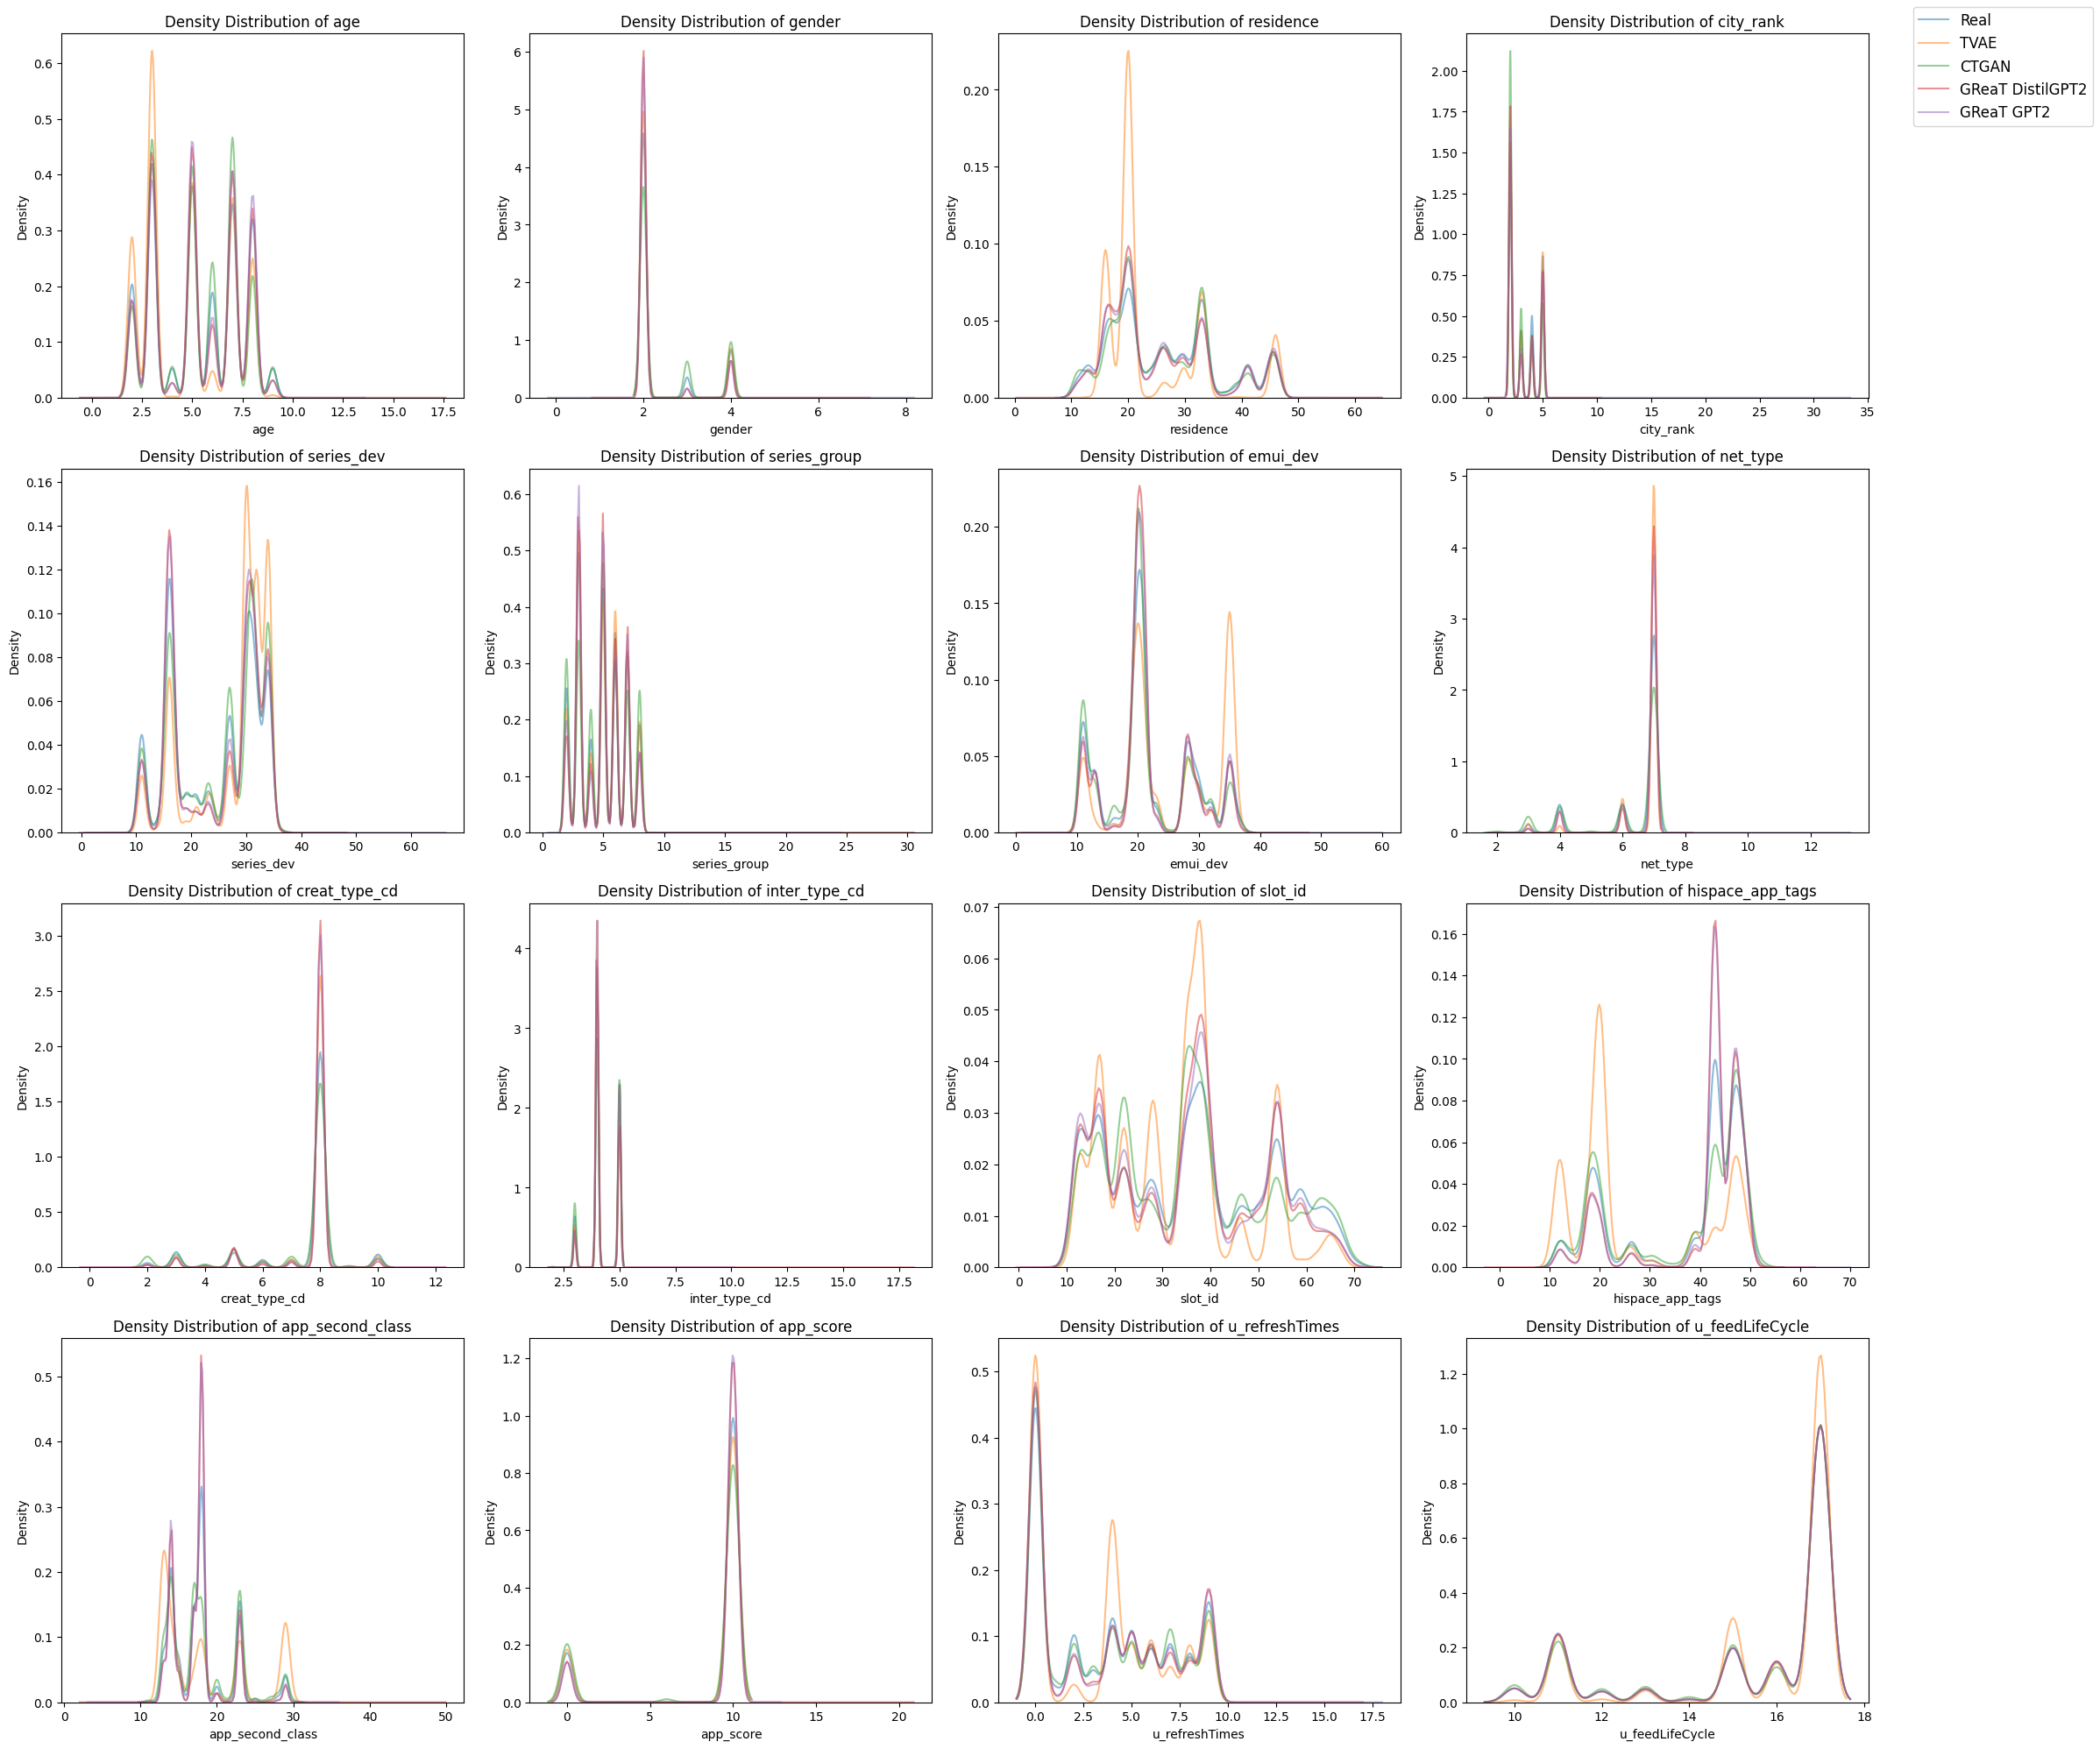

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_distribution(ax, real, synthetic1, synthetic2, synthetic3,synthetic4, feature):
    # Plot density distribution for each dataset on the given axis
    sns.kdeplot(data=real, x=feature, label="Real", common_norm=False, alpha=0.5, ax=ax)
    sns.kdeplot(data=synthetic1, x=feature, label="TVAE", common_norm=False, alpha=0.5, ax=ax)
    sns.kdeplot(data=synthetic2, x=feature, label="CTGAN", common_norm=False, alpha=0.5, ax=ax)
    sns.kdeplot(data=synthetic3, x=feature, label="GReaT DistilGPT2", common_norm=False, alpha=0.5, ax=ax)
    sns.kdeplot(data=synthetic4, x=feature, label="GReaT GPT2", common_norm=False, alpha=0.5, ax=ax)
    ax.set_title(f"Density Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    # Optionally, remove the legend here to avoid duplicates in each subplot
    ax.legend().remove()

# Get features excluding the target variable
features = [col for col in real_data_label1.columns if col != "label"]

# Create a 4x4 grid for the 16 features
fig, axes = plt.subplots(4, 4, figsize=(24, 20))
axes = axes.flatten()

# Loop through features and plot each on a corresponding subplot
for i, feature in enumerate(features):
    plot_density_distribution(axes[i], real_data_label1, synthetic_tvae, synthetic_ctgan, synthetic_great_distilGPT2, synthetic_great_GPT2, feature)

# Remove any unused subplots if there are less than 16 features
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize='large')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for the legend
plt.savefig("density_distribution.png", dpi=300)
plt.show()


# Classifier-Based Evaluation - Logistic Regression

This approach trains a classifier to distinguish between real and synthetic samples. If the classifier struggles (accuracy near 50%), it means the synthetic data is close to the real data. Here’s an example using logistic regression:

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def evaluate_classifier(real, synthetic, label="Synthetic"):
    # Convert DataFrames to NumPy arrays (assumes same feature columns)
    X_real = real.values
    X_synthetic = synthetic.values
    # Label 1 for real data, 0 for synthetic data
    y_real = np.ones(X_real.shape[0])
    y_synthetic = np.zeros(X_synthetic.shape[0])

    # Combine the datasets
    X = np.concatenate([X_real, X_synthetic], axis=0)
    y = np.concatenate([y_real, y_synthetic], axis=0)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a logistic regression classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # Evaluate the classifier
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classifier Accuracy (Real vs. {label}): {accuracy:.4f}")
    return accuracy

# Evaluate each synthetic dataset
accuracy_ctgan = evaluate_classifier(real_data_label1, synthetic_ctgan, label="CTGAN")
accuracy_ctgan = evaluate_classifier(real_data_label1, synthetic_tvae, label="TVAE")
accuracy_distilgpt2 = evaluate_classifier(real_data_label1, synthetic_great_distilGPT2, label="DistilGPT2")
accuracy_gpt2 = evaluate_classifier(real_data_label1, synthetic_great_GPT2, label="GPT2")


Classifier Accuracy (Real vs. CTGAN): 0.6047
Classifier Accuracy (Real vs. TVAE): 0.7392
Classifier Accuracy (Real vs. DistilGPT2): 0.5952
Classifier Accuracy (Real vs. GPT2): 0.5908


Magnitude of Difference: An accuracy of ~60.5% shows a moderate gap. The classifier is only 10.5 percentage points above chance, suggesting that while the synthetic data mimics some aspects of the real data, there are still detectable discrepancies.

# Maximum Mean Discrepancy (MMD)

MMD is a kernel-based metric that quantifies the distance between two distributions. A lower MMD value indicates that the synthetic data distribution is closer to the real on

In [ ]:
import numpy as np

def gaussian_kernel(x, y, gamma=1.0):
    """
    Computes the Gaussian (RBF) kernel between two matrices.
    """
    x_norm = np.sum(x**2, axis=1).reshape(-1, 1)
    y_norm = np.sum(y**2, axis=1).reshape(1, -1)
    sq_dist = x_norm + y_norm - 2 * np.dot(x, y.T)
    return np.exp(-gamma * sq_dist)

def compute_mmd(x, y, gamma=1.0):
    """
    Computes the unbiased estimator of the squared MMD between x and y.
    """
    n, m = x.shape[0], y.shape[0]
    k_xx = gaussian_kernel(x, x, gamma)
    k_yy = gaussian_kernel(y, y, gamma)
    k_xy = gaussian_kernel(x, y, gamma)

    # Exclude diagonal for k_xx and k_yy
    sum_kxx = (np.sum(k_xx) - np.sum(np.diag(k_xx))) / (n * (n - 1))
    sum_kyy = (np.sum(k_yy) - np.sum(np.diag(k_yy))) / (m * (m - 1))
    sum_kxy = np.sum(k_xy) / (n * m)

    mmd = sum_kxx + sum_kyy - 2 * sum_kxy
    return mmd

def evaluate_mmd(real, synthetic, label="Synthetic", gamma=0.1, n_samples=10000):
    # Convert to NumPy arrays
    X_real = real.values
    X_synthetic = synthetic.values

    # Optionally subsample for faster computation
    if X_real.shape[0] > n_samples:
        idx = np.random.choice(X_real.shape[0], n_samples, replace=False)
        X_real = X_real[idx]
    if X_synthetic.shape[0] > n_samples:
        idx = np.random.choice(X_synthetic.shape[0], n_samples, replace=False)
        X_synthetic = X_synthetic[idx]

    mmd_val = compute_mmd(X_real, X_synthetic, gamma=gamma)
    print(f"MMD (Real vs. {label}): {mmd_val:.7f}")
    return mmd_val

# Evaluate MMD for each synthetic dataset
mmd_ctgan = evaluate_mmd(real_data_label1, synthetic_ctgan, label="CTGAN", gamma=0.1)
mmd_distilgpt2 = evaluate_mmd(real_data_label1, synthetic_great_distilGPT2, label="DistilGPT2", gamma=0.1)
mmd_gpt2 = evaluate_mmd(real_data_label1, synthetic_great_GPT2, label="GPT2", gamma=0.1)


MMD (Real vs. CTGAN): 0.0000718
MMD (Real vs. DistilGPT2): 0.0000656
MMD (Real vs. GPT2): 0.0000656


A lower MMD value indicates that the synthetic data distribution is more similar to the real data distribution (i.e., higher fidelity).
Compare the MMD values across CTGAN, DistilGPT2, and GPT2 synthetic datasets to see which one more closely approximates the real data.

In [18]:
from scipy.spatial.distance import jensenshannon

def compute_jsd_categorical(real, synthetic):
    jsd_scores = {}

    for col in real.columns:
        real_dist = real[col].value_counts(normalize=True)
        synthetic_dist = synthetic[col].value_counts(normalize=True)

        # Align index (fill missing categories with 0)
        common_categories = real_dist.index.union(synthetic_dist.index)
        real_dist = real_dist.reindex(common_categories, fill_value=0)
        synthetic_dist = synthetic_dist.reindex(common_categories, fill_value=0)

        # Compute JSD
        jsd = jensenshannon(real_dist, synthetic_dist)
        jsd_scores[col] = jsd

    return pd.DataFrame(jsd_scores.items(), columns=["Feature", "JSD Score"])

jsd_ctgan = compute_jsd_categorical(real_data_label1, synthetic_ctgan)
jsd_tvae = compute_jsd_categorical(real_data_label1, synthetic_tvae)
jsd_great_distilgpt2 = compute_jsd_categorical(real_data_label1, synthetic_great_distilGPT2)
jsd_great_gpt2 = compute_jsd_categorical(real_data_label1, synthetic_great_GPT2)
jsd_ctgan.rename(columns={"JSD Score": "CTGAN"}, inplace=True)
jsd_tvae.rename(columns={"JSD Score": "TVAE"}, inplace=True)
jsd_great_distilgpt2.rename(columns={"JSD Score": "DistilGPT2"}, inplace=True)
jsd_great_gpt2.rename(columns={"JSD Score": "GPT2"}, inplace=True)
# Display results in Pandas
#print("JSD Scores - CTGAN")
#print(jsd_ctgan)
#print("\nJSD Scores - GReaT")
#print(jsd_great)
combined_jsd = pd.merge(jsd_tvae, jsd_ctgan, on="Feature", how="outer")
combined_jsd = pd.merge(combined_jsd, jsd_great_distilgpt2, on="Feature", how="outer")
combined_jsd = pd.merge(combined_jsd, jsd_great_gpt2, on="Feature", how="outer")
combined_jsd


,Feature,TVAE,CTGAN,DistilGPT2,GPT2
0,age,0.181051,0.077138,0.068496,0.069658
1,app_score,0.019761,0.070496,0.046615,0.047919
2,app_second_class,0.317083,0.152890,0.122578,0.119174
3,city_rank,0.055582,0.118697,0.079165,0.059775
4,creat_type_cd,0.071569,0.075454,0.122139,0.108252
5,emui_dev,0.235147,0.131999,0.107088,0.089582
6,gender,0.147340,0.087916,0.087937,0.086044
7,hispace_app_tags,0.383423,0.127757,0.147048,0.140991
8,inter_type_cd,0.038877,0.068092,0.056481,0.049431
9,label,0.000000,0.000000,0.000000,0.000000


In [19]:
print(sum(combined_jsd["CTGAN"]))
print(sum(combined_jsd["TVAE"]))
print(sum(combined_jsd["DistilGPT2"]))
print(sum(combined_jsd["GPT2"]))

1.530089892811226
2.947479637911099
1.40440842918645
1.3082608053362497


- JSD measures the similarity between probability distributions:
- JSD = 0 → Identical distributions (perfect fidelity).
- JSD closer to 0 → Higher similarity.
- JSD > 0.1 → Noticeable difference.
- JSD > 0.15 → Significant difference (poor fidelity).

# Utility: CTGAN VS GReaT

# TSTR (Train on Synthetic Data, Test on Real Data)

### Alternatively,evaluate the predictive power by training a model solely on the synthetic label 1 (plus real label 0) and then testing it on a hold‐out set from the original real data.

In [10]:
syntetic_data_label1_GReaT_DistilGPT2["label"] = 1
syntetic_data_label1_GReaT_GPT2["label"] = 1

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Real Balanced Data Evaluation:
  Accuracy:  0.7142
  F1 Score:  0.7105
  AUC-ROC:   0.7968
  Precision: 0.7199
  Recall:    0.7013
Confusion Matrix:
[[17326  6502]
 [ 7117 16710]]


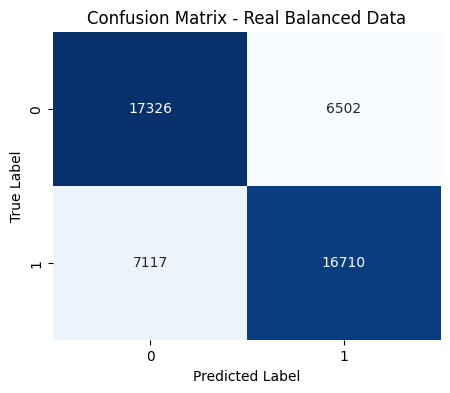

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CTGAN TSTR Model Evaluation:
  Accuracy:  0.5222
  F1 Score:  0.0971
  AUC-ROC:   0.7081
  Precision: 0.8800
  Recall:    0.0514
Confusion Matrix:
[[23661   167]
 [22602  1225]]


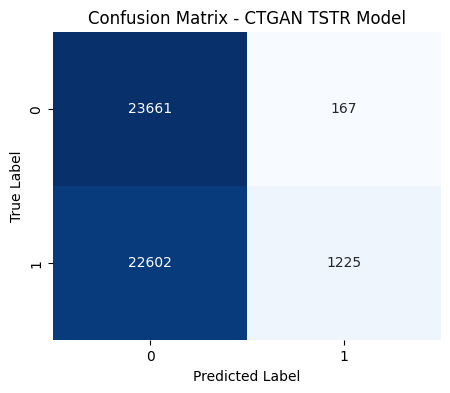

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


TVAE TSTR Model Evaluation:
  Accuracy:  0.5379
  F1 Score:  0.2011
  AUC-ROC:   0.6060
  Precision: 0.7412
  Recall:    0.1163
Confusion Matrix:
[[22860   968]
 [21055  2772]]


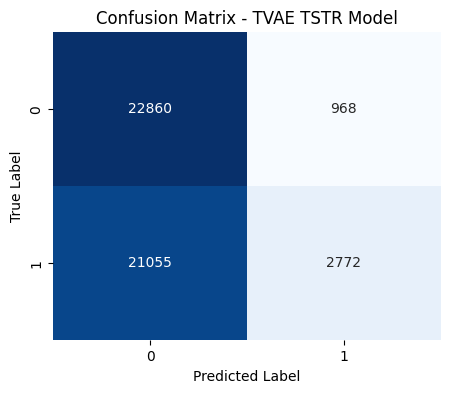

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GReaT DistilGPT2 TSTR Model Evaluation:
  Accuracy:  0.6280
  F1 Score:  0.4969
  AUC-ROC:   0.7375
  Precision: 0.7672
  Recall:    0.3675
Confusion Matrix:
[[21171  2657]
 [15071  8756]]


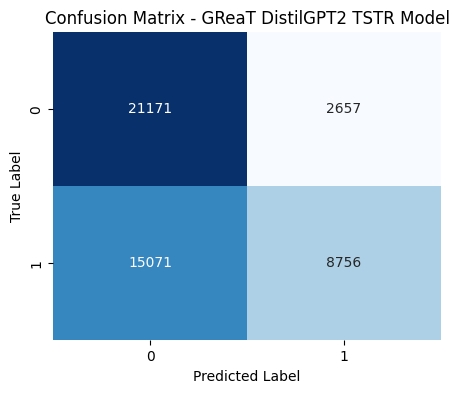

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GReaT GPT2 TSTR Model Evaluation:
  Accuracy:  0.6632
  F1 Score:  0.6100
  AUC-ROC:   0.7499
  Precision: 0.7246
  Recall:    0.5267
Confusion Matrix:
[[19058  4770]
 [11278 12549]]


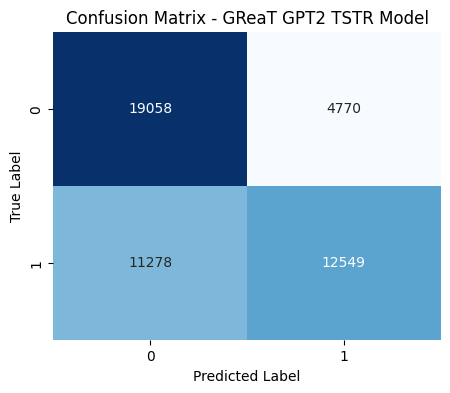

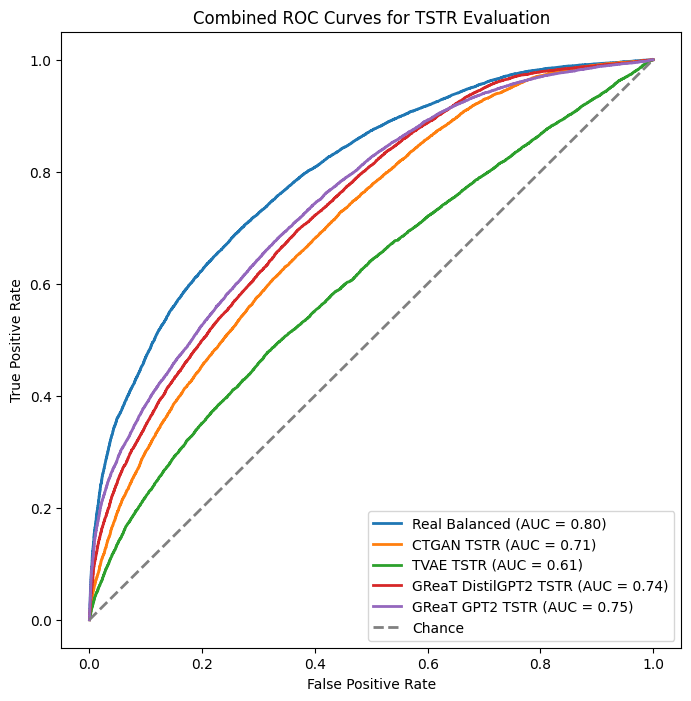

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score, confusion_matrix,
                             roc_curve, auc)

random_state = 42

# Extract real label 0 from the full dataset
real_label0 = train_ads_minimal[train_ads_minimal["label"] == 0]

# Get the number of label 1 examples (should be 119,136)
n_label1 = len(train_ads_minimal_label1)

# Sample real label 0 to match the number of label 1 examples
real_label0_sample = real_label0.sample(n=n_label1, random_state=random_state)

# Create Real Balanced Data: real label 0 (sampled) + real label 1
real_balanced = pd.concat([real_label0_sample, train_ads_minimal_label1], axis=0)

# Create Augmented Data using CTGAN synthetic label 1
augmented_ctgan = pd.concat([real_label0_sample, syntetic_data_label1_CTGAN], axis=0)

# Create Augmented Data using TVAE synthetic label 1
augmented_tvae = pd.concat([real_label0_sample, syntetic_data_label1_TVAE], axis=0)

# Create Augmented Data using GReaT synthetic label 1 (DistilGPT2 version)
augmented_great_distilgpt2 = pd.concat([real_label0_sample, syntetic_data_label1_GReaT_DistilGPT2], axis=0)

# Create Augmented Data using GReaT synthetic label 1 (GPT2 version)
augmented_great_gpt2 = pd.concat([real_label0_sample, syntetic_data_label1_GReaT_GPT2], axis=0)

# ---------------------------
# Step 2: Create Train/Test Splits
# ---------------------------

# For baseline evaluation, split the Real Balanced Data into train and test sets
X_real = real_balanced.drop(columns=["label"])
y_real = real_balanced["label"]

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=random_state, stratify=y_real
)

# For TSTR evaluation, use the entire augmented datasets as training data

# CTGAN
X_train_ctgan = augmented_ctgan.drop(columns=["label"])
y_train_ctgan = augmented_ctgan["label"]

# TVAE
X_train_tvae = augmented_tvae.drop(columns=["label"])
y_train_tvae = augmented_tvae["label"]

# GReaT DistilGPT2
X_train_great_distilgpt2 = augmented_great_distilgpt2.drop(columns=["label"])
y_train_great_distilgpt2 = augmented_great_distilgpt2["label"]

# GReaT GPT2
X_train_great_gpt2 = augmented_great_gpt2.drop(columns=["label"])
y_train_great_gpt2 = augmented_great_gpt2["label"]

# ---------------------------
# Step 3: Train and Evaluate Models with XGBoost
# ---------------------------

def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"{dataset_name} Evaluation:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc_val:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")

    # Compute and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return model

# Baseline: Train on Real Balanced Data (Real label0 + real label1)
model_real = train_and_evaluate(X_train_real, y_train_real, X_test_real, y_test_real, "Real Balanced Data")

# TSTR: Train on CTGAN Augmented Data (Real label0 + CTGAN synthetic label1)
model_ctgan = train_and_evaluate(X_train_ctgan, y_train_ctgan, X_test_real, y_test_real, "CTGAN TSTR Model")

# TSTR: Train on TVAE Augmented Data (Real label0 + TVAE synthetic label1)
model_tvae = train_and_evaluate(X_train_tvae, y_train_tvae, X_test_real, y_test_real, "TVAE TSTR Model")

# TSTR: Train on GReaT Augmented Data (Real label0 + GReaT synthetic label1 - DistilGPT2)
model_great_distilgpt2 = train_and_evaluate(X_train_great_distilgpt2, y_train_great_distilgpt2, X_test_real, y_test_real, "GReaT DistilGPT2 TSTR Model")

# TSTR: Train on GReaT Augmented Data (Real label0 + GReaT synthetic label1 - GPT2)
model_great_gpt2 = train_and_evaluate(X_train_great_gpt2, y_train_great_gpt2, X_test_real, y_test_real, "GReaT GPT2 TSTR Model")

# ---------------------------
# Step 4: Plot Combined ROC Curves
# ---------------------------

def plot_combined_roc(models, X_test, y_test, labels, title="Combined ROC Curves for TSTR Evaluation"):
    plt.figure(figsize=(8, 8))
    for model, label in zip(models, labels):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot the ROC curves for all models using the common real test set
plot_combined_roc(
    models=[model_real, model_ctgan, model_tvae, model_great_distilgpt2, model_great_gpt2],
    X_test=X_test_real,
    y_test=y_test_real,
    labels=["Real Balanced", "CTGAN TSTR", "TVAE TSTR", "GReaT DistilGPT2 TSTR", "GReaT GPT2 TSTR"]
)


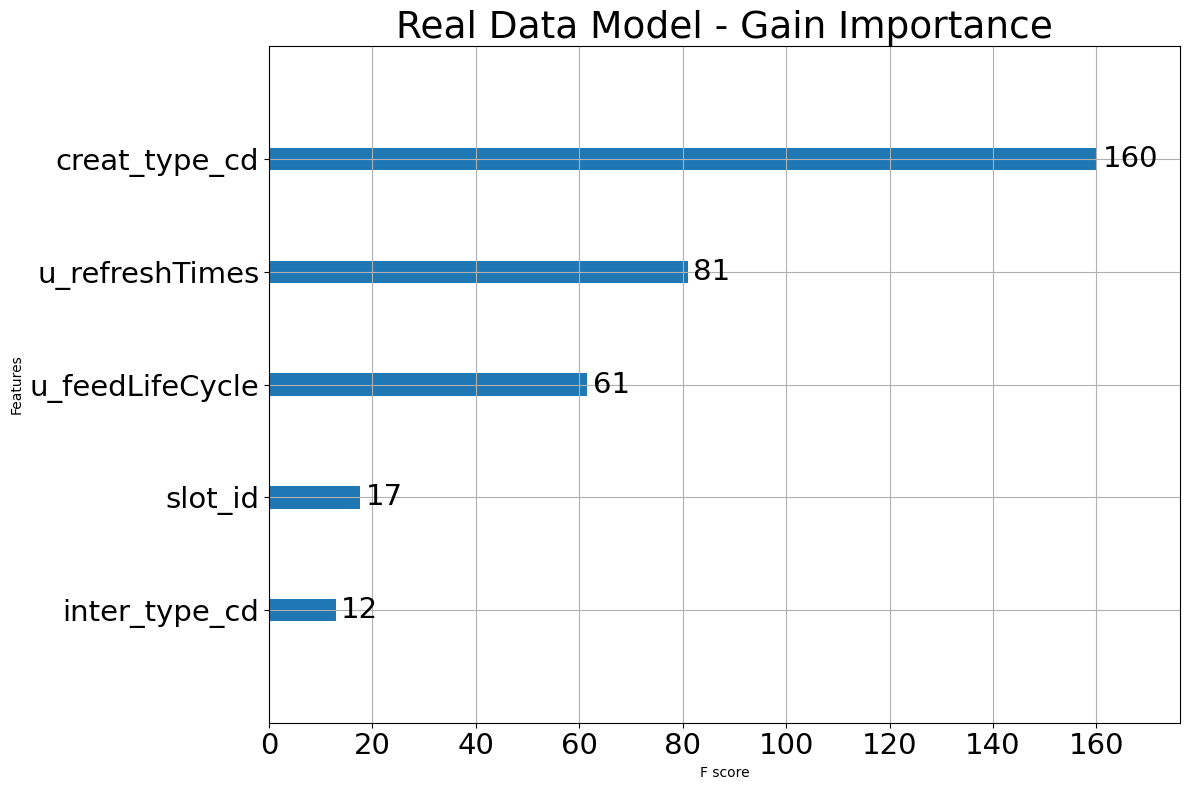

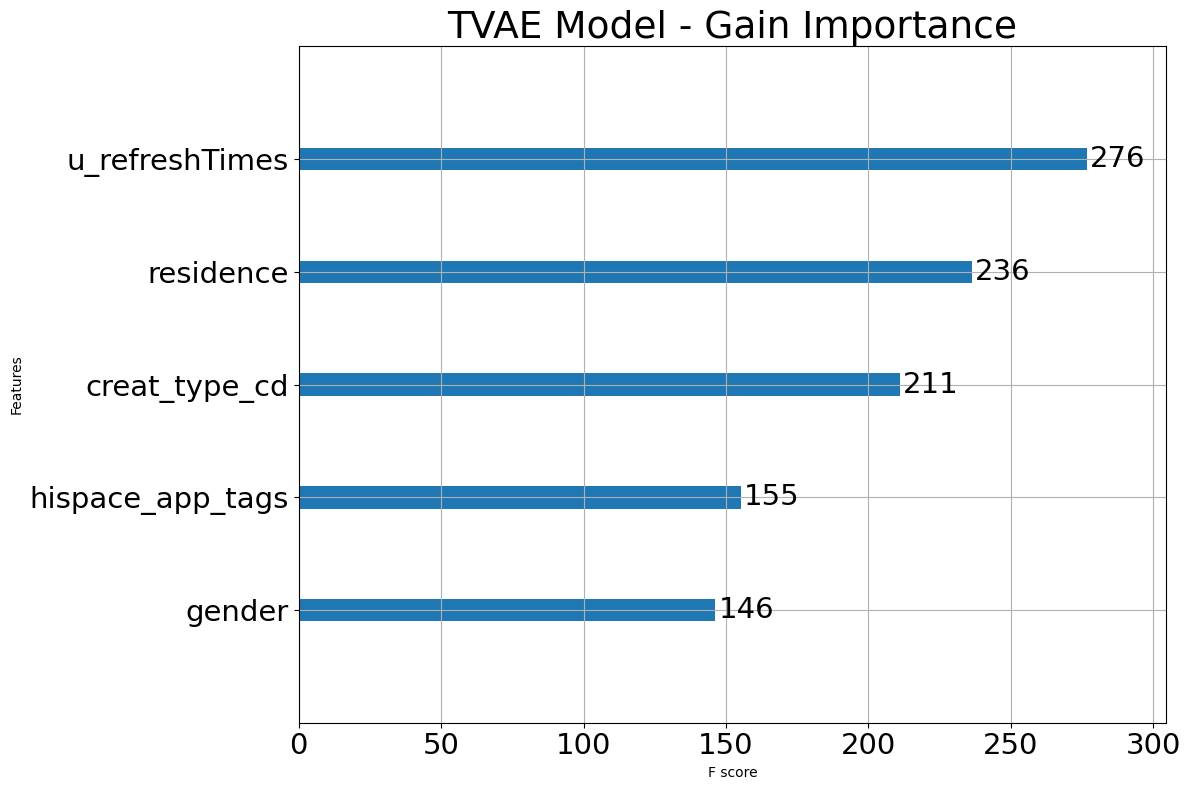

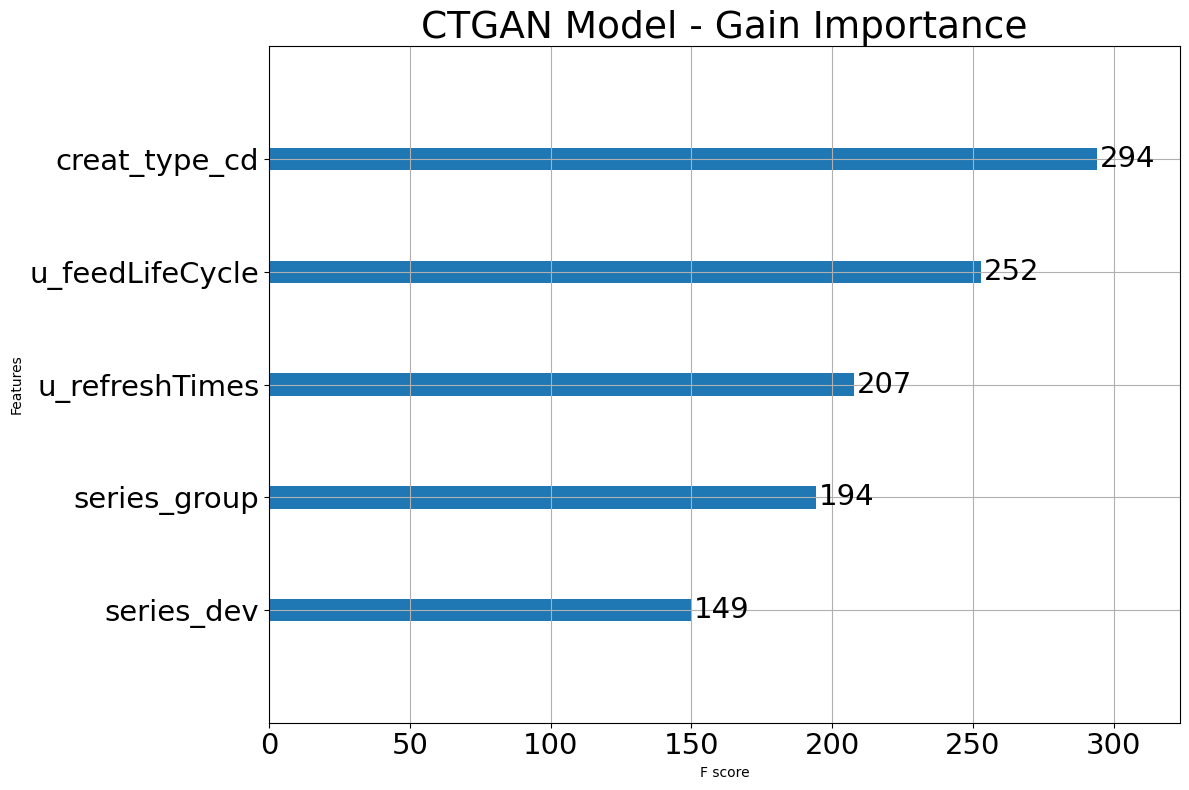

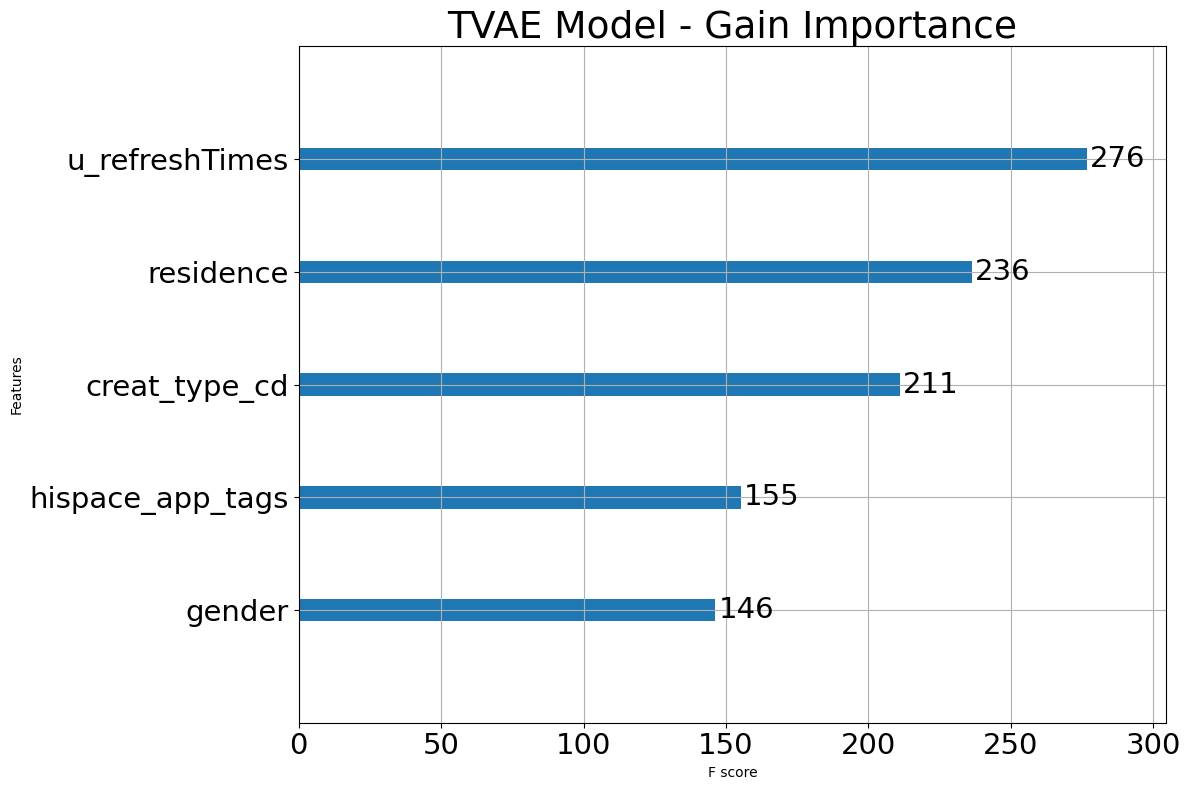

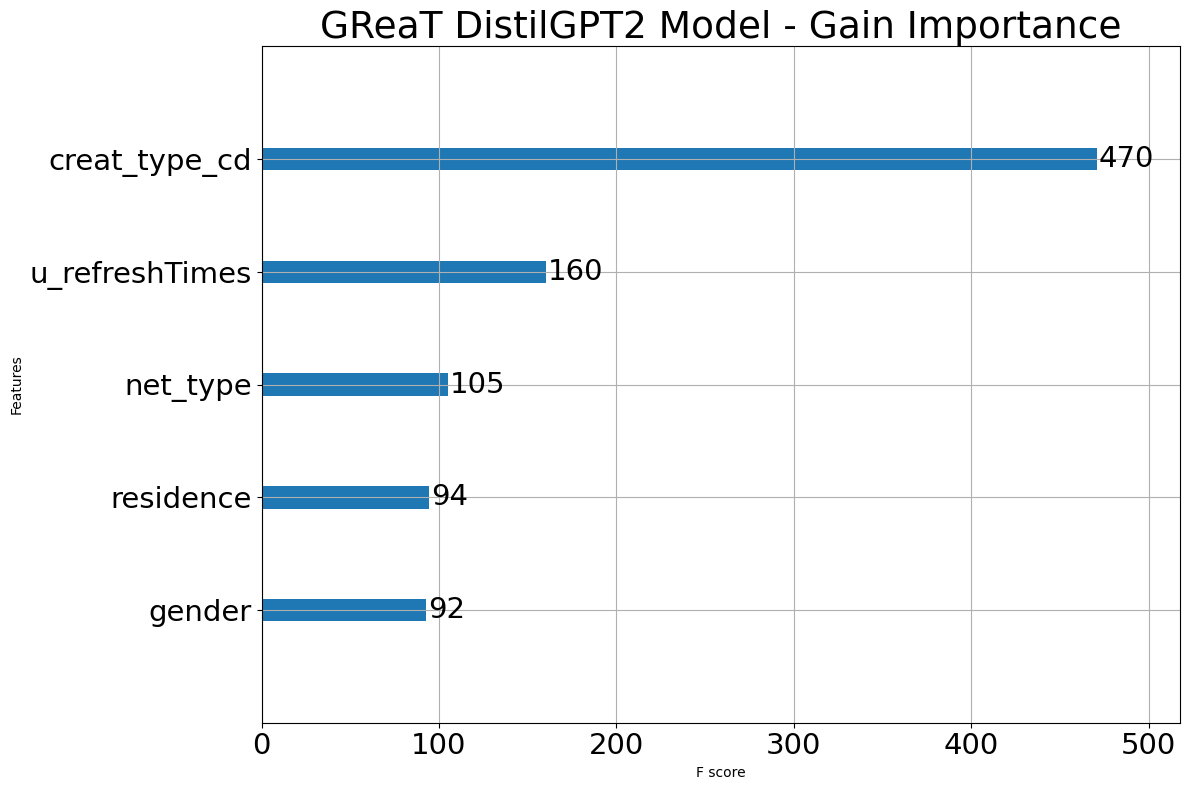

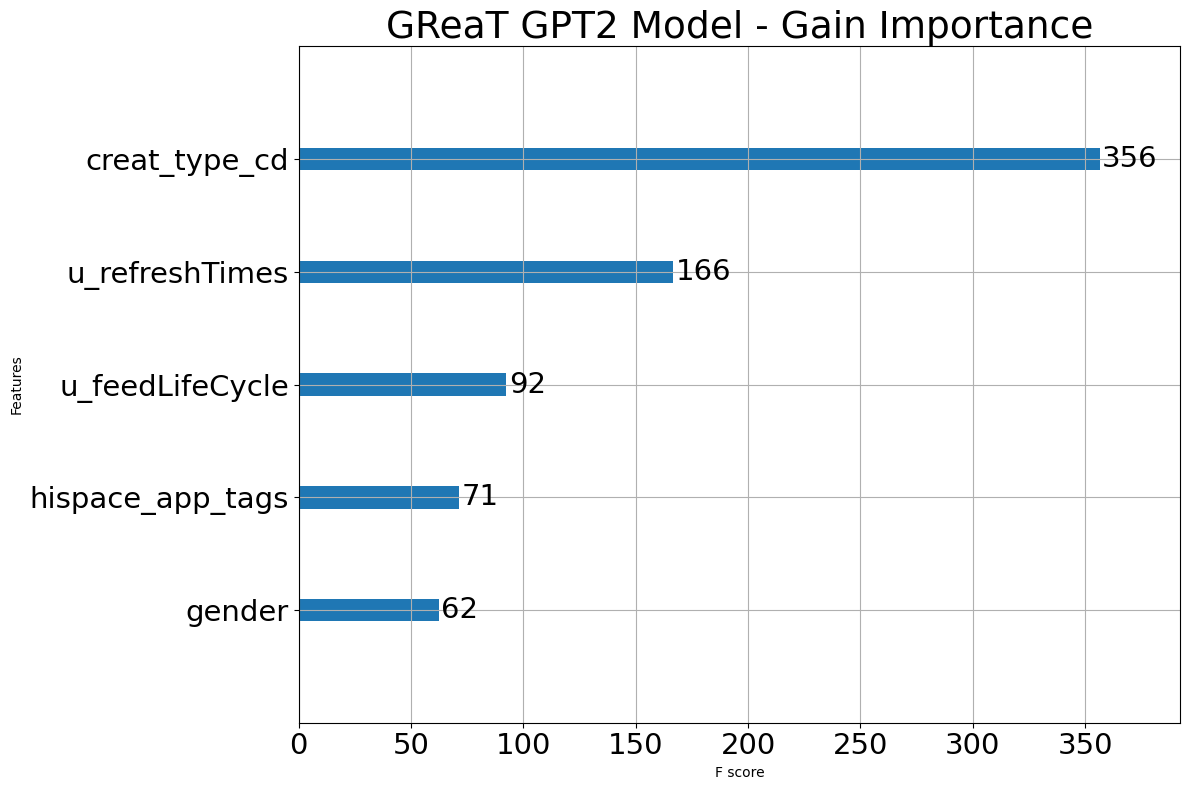

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from xgboost import plot_importance

def adjust_text_labels(ax, fontsize=14):
    # Iterate over all text elements in the axis and set font size and integer formatting
    for text in ax.texts:
        try:
            value = float(text.get_text())
            text.set_text(f'{int(value)}')
            text.set_fontsize(fontsize)
        except ValueError:
            continue

# Real Data Model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_real, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
ax.tick_params(axis='both', labelsize=21)
plt.title("Real Data Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()

# TVAE
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_tvae, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
ax.tick_params(axis='both', labelsize=21)
plt.title("TVAE Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()

# CTGAN Model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_ctgan, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
ax.tick_params(axis='both', labelsize=21)
plt.title("CTGAN Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()

# TVAE model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_tvae, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
ax.tick_params(axis='both', labelsize=21)
plt.title("TVAE Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()

# GReaT DistilGPT2 Model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_great_distilgpt2, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
ax.tick_params(axis='both', labelsize=21)
plt.title("GReaT DistilGPT2 Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()

# GReaT GPT2 Model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_great_gpt2, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
ax.tick_params(axis='both', labelsize=21)
plt.title("GReaT GPT2 Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()


In [33]:
real_data.columns

Index(['label', 'age', 'gender', 'residence', 'city_rank', 'series_dev',
       'series_group', 'emui_dev', 'net_type', 'creat_type_cd',
       'inter_type_cd', 'slot_id', 'hispace_app_tags', 'app_second_class',
       'app_score', 'u_refreshTimes', 'u_feedLifeCycle'],
      dtype='object')

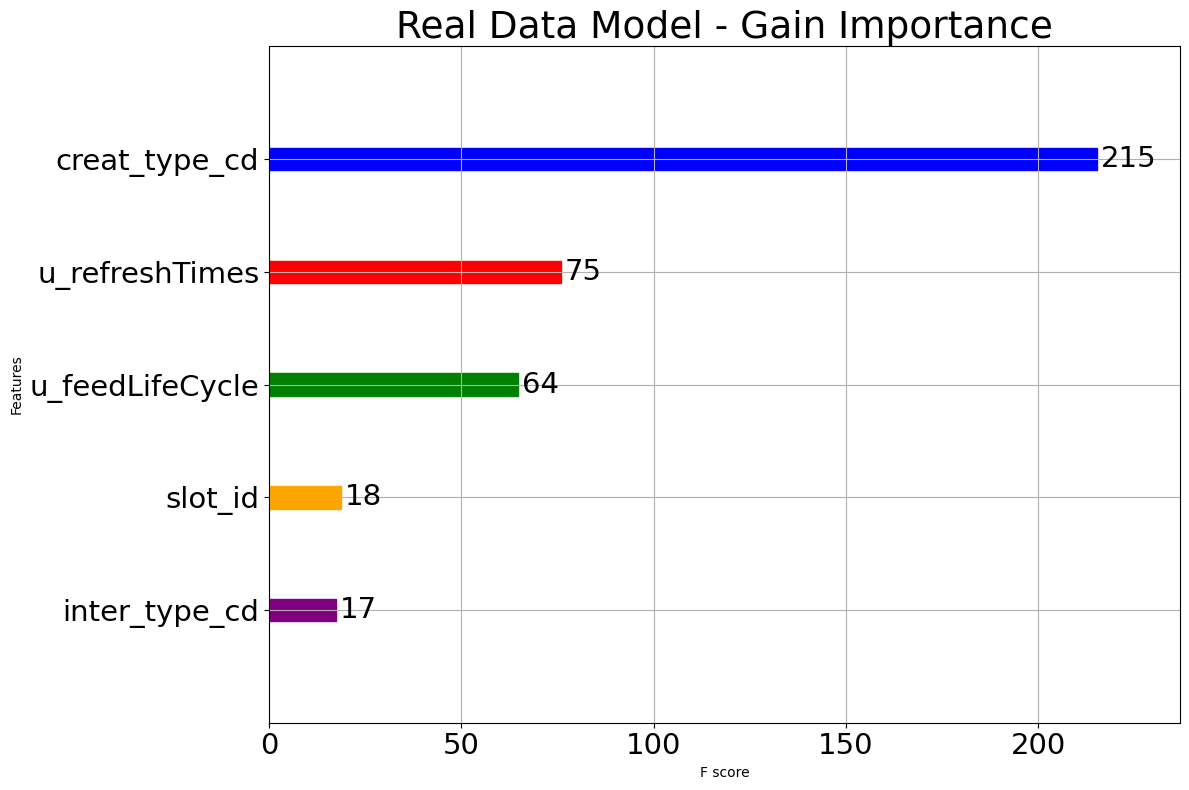

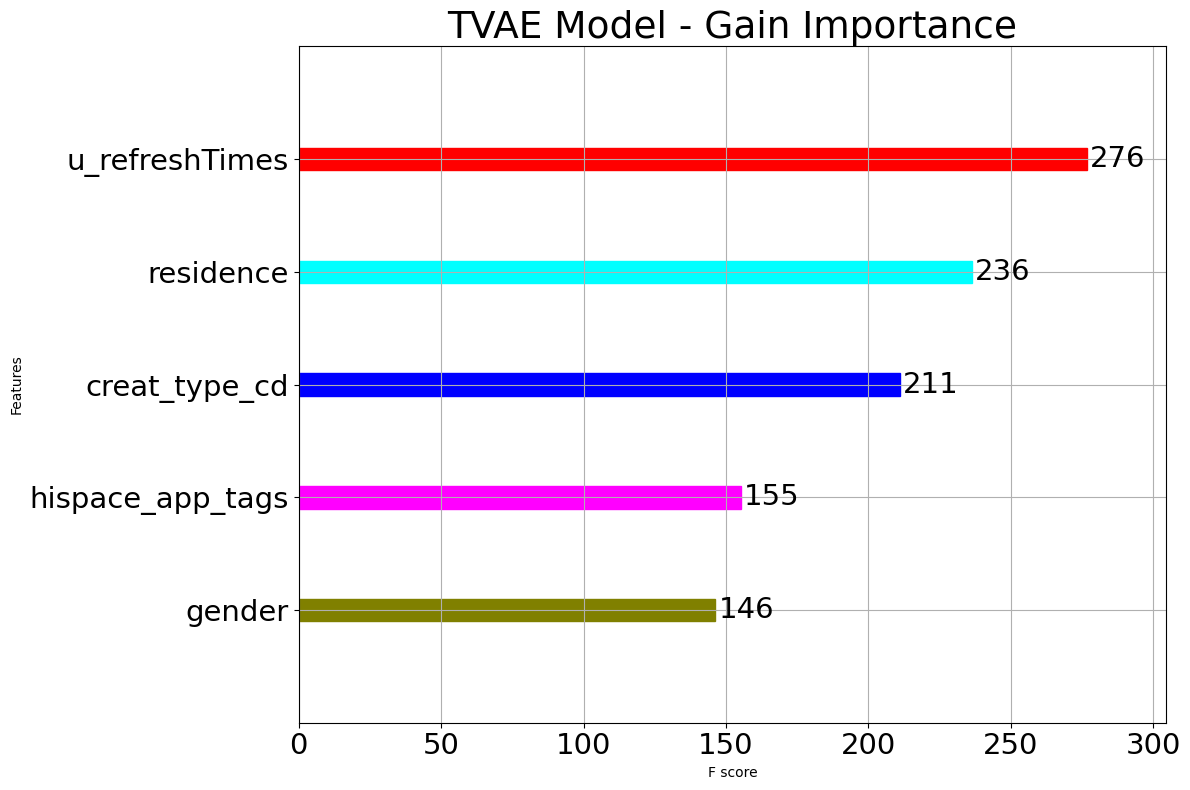

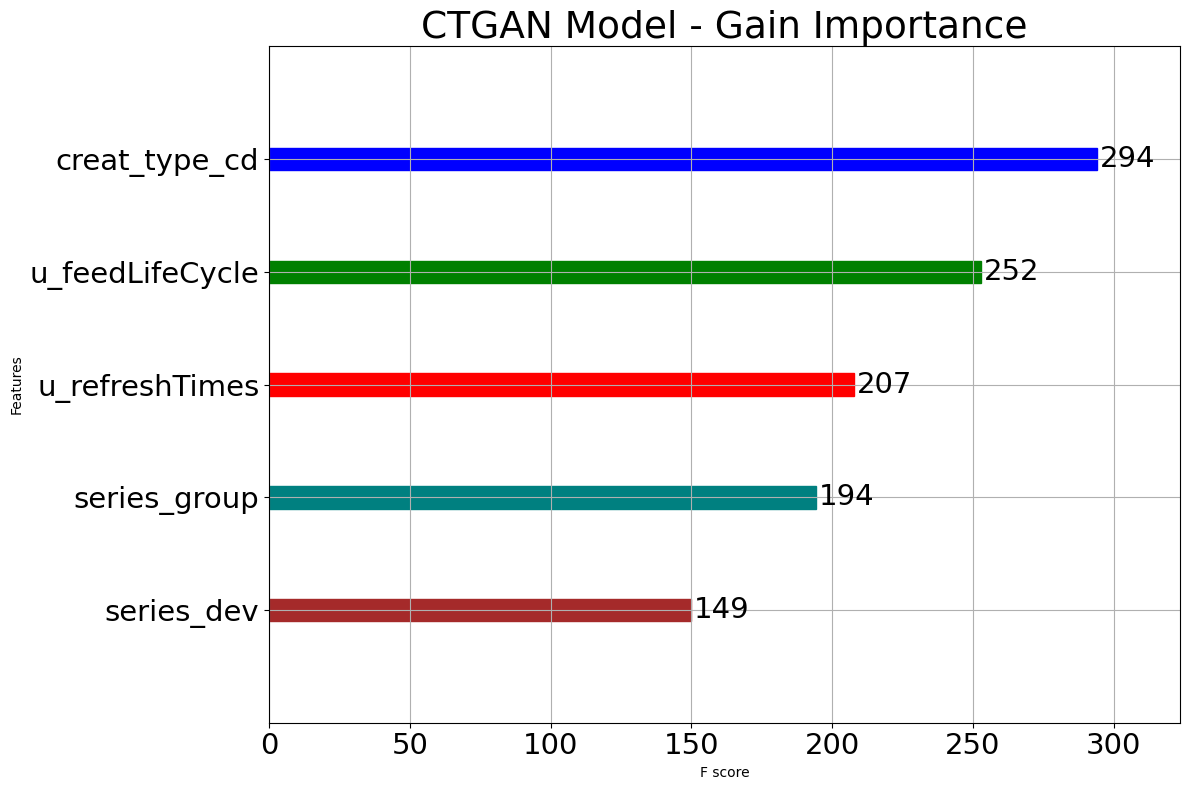

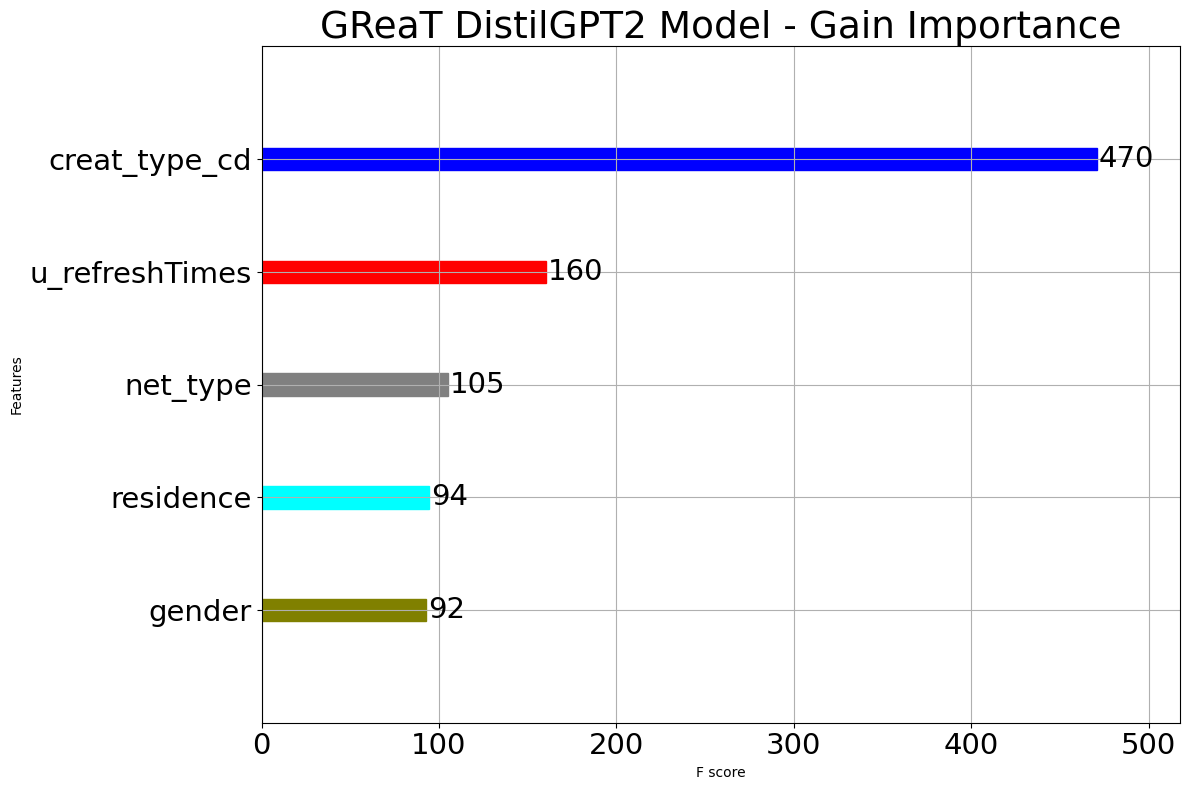

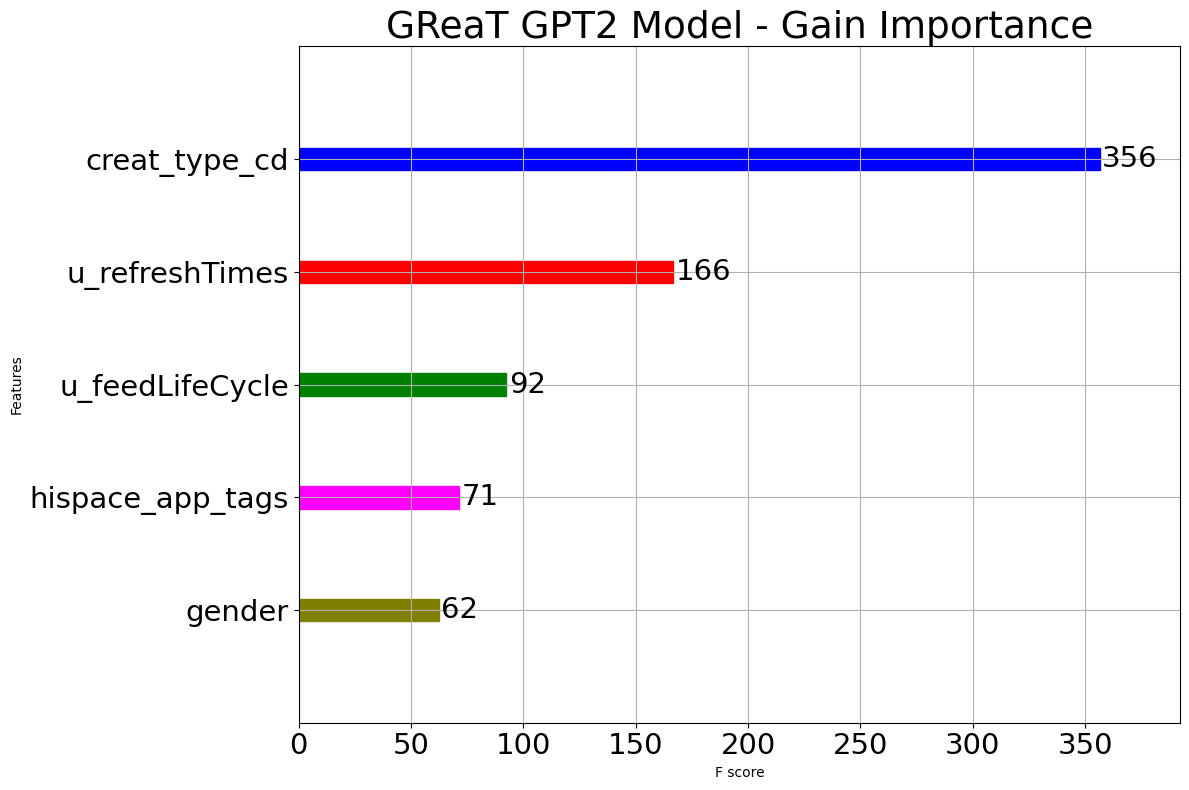

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from xgboost import plot_importance

def adjust_text_labels(ax, fontsize=14):
    # Iterate over all text elements in the axis and set font size and integer formatting
    for text in ax.texts:
        try:
            value = float(text.get_text())
            text.set_text(f'{int(value)}')
            text.set_fontsize(fontsize)
        except ValueError:
            continue

def assign_bar_colors(ax, color_map, default_color='gray'):
    # Extract the feature names from the y-axis tick labels.
    # In XGBoost's plot_importance, the feature names appear on the y-axis.
    tick_labels = [tick.get_text() for tick in ax.get_yticklabels()]

    # Iterate over the bars (patches) and assign the color based on the feature name.
    for patch, feature in zip(ax.patches, tick_labels):
        patch.set_color(color_map.get(feature, default_color))

# Define a color map for the features.
# Update the keys with your actual feature names and the desired colors.
color_map = {
    'creat_type_cd': 'blue',
    'u_refreshTimes': 'red',
    'u_feedLifeCycle': 'green',
    'slot_id': 'orange',
    'inter_type_cd': 'purple',
    'residence': 'cyan',
    'hispace_app_tags': 'magenta',
    'gender': 'olive',
    'series_group': 'teal',
    'series_dev': 'brown',
    'net_type': 'grey'
}


# Real Data Model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_real, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
assign_bar_colors(ax, color_map)
ax.tick_params(axis='both', labelsize=21)
plt.title("Real Data Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()

# TVAE Model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_tvae, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
assign_bar_colors(ax, color_map)
ax.tick_params(axis='both', labelsize=21)
plt.title("TVAE Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()

# CTGAN Model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_ctgan, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
assign_bar_colors(ax, color_map)
ax.tick_params(axis='both', labelsize=21)
plt.title("CTGAN Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()

# GReaT DistilGPT2 Model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_great_distilgpt2, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
assign_bar_colors(ax, color_map)
ax.tick_params(axis='both', labelsize=21)
plt.title("GReaT DistilGPT2 Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()

# GReaT GPT2 Model
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(model_great_gpt2, importance_type='gain', max_num_features=5, ax=ax)
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%d'))
adjust_text_labels(ax, fontsize=21)
assign_bar_colors(ax, color_map)
ax.tick_params(axis='both', labelsize=21)
plt.title("GReaT GPT2 Model - Gain Importance", fontsize=27)
plt.tight_layout()
plt.show()


# 10 folds cross validation

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:36:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 1 completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 2 completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 3 completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 4 completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:37:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 5 completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 6 completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 7 completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 8 completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 9 completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:38:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:39:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Fold 10 completed.

Average Evaluation Metrics (10-Fold CV):
                             Accuracy  F1 Score   AUC-ROC  Precision    Recall
Real Balanced Data           0.714985  0.710632  0.797766   0.721655  0.699956
TVAE TSTR Model              0.538729  0.204473  0.612060   0.742521  0.118570
CTGAN TSTR Model             0.521530  0.094994  0.710047   0.874877  0.050228
GReaT DistilGPT2 TSTR Model  0.629931  0.499256  0.739487   0.771762  0.368990
GReaT GPT2 TSTR Model        0.666331  0.614320  0.752883   0.727755  0.531493


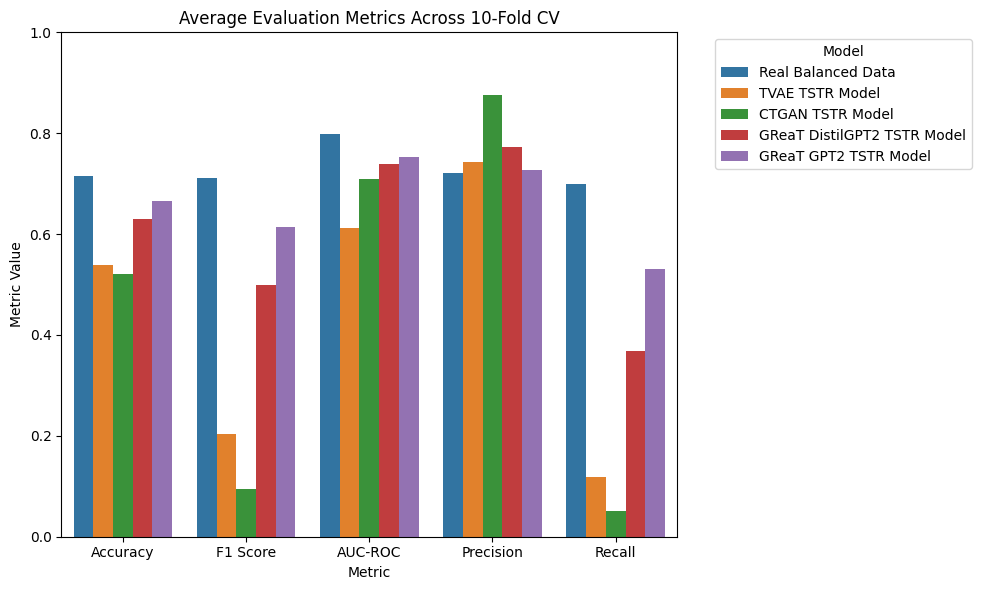

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score)

random_state = 42

# ---------------------------
# Data Preparation (as before)
# ---------------------------

# Assume these DataFrames are already loaded:
# train_ads_minimal: full dataset with both labels (shape: (7,675,517, 17))
# train_ads_minimal_label1: real label 1 data (shape: (119,136, 17))
# syntetic_data_label1_CTGAN: CTGAN-synthesized data for label 1 (shape: (119,136, 17))
# syntetic_data_label1_GReaT_DistilGPT2: GReaT DistilGPT2-synthesized data for label 1 (shape: (119,136, 17))
# syntetic_data_label1_GReaT_GPT2: GReaT GPT2-synthesized data for label 1 (shape: (119,136, 17))

# Extract real label 0 from the full dataset
real_label0 = train_ads_minimal[train_ads_minimal["label"] == 0]

# Get the number of label 1 examples (should be 119,136)
n_label1 = len(train_ads_minimal_label1)

# Sample real label 0 to match the number of label 1 examples
real_label0_sample = real_label0.sample(n=n_label1, random_state=random_state)

# Create Real Balanced Data: real label 0 (sampled) + real label 1
real_balanced = pd.concat([real_label0_sample, train_ads_minimal_label1], axis=0)

# Create Augmented Data using synthetic label 1 from different methods
augmented_ctgan = pd.concat([real_label0_sample, syntetic_data_label1_CTGAN], axis=0)
augmented_tvae = pd.concat([real_label0_sample, syntetic_data_label1_TVAE], axis=0)
augmented_great_distilgpt2 = pd.concat([real_label0_sample, syntetic_data_label1_GReaT_DistilGPT2], axis=0)
augmented_great_gpt2 = pd.concat([real_label0_sample, syntetic_data_label1_GReaT_GPT2], axis=0)

# ---------------------------
# Prepare for 10-Fold Cross Validation
# ---------------------------

# Define features and labels for the real balanced dataset (used for test splits)
X_real = real_balanced.drop(columns=["label"])
y_real = real_balanced["label"]

X_tvae = augmented_tvae.drop(columns=["label"])
y_real = augmented_tvae["label"]

# For the synthetic/TSTR models, training data remains constant
X_train_ctgan = augmented_ctgan.drop(columns=["label"])
y_train_ctgan = augmented_ctgan["label"]

X_train_great_distilgpt2 = augmented_great_distilgpt2.drop(columns=["label"])
y_train_great_distilgpt2 = augmented_great_distilgpt2["label"]

X_train_great_gpt2 = augmented_great_gpt2.drop(columns=["label"])
y_train_great_gpt2 = augmented_great_gpt2["label"]

# Initialize StratifiedKFold
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize lists to store metrics for each fold/model
metrics_real_cv = []
metrics_tvae_cv = []
metrics_ctgan_cv = []
metrics_great_distilgpt2_cv = []
metrics_great_gpt2_cv = []

# ---------------------------
# Cross Validation Loop
# ---------------------------
for fold, (train_idx, test_idx) in enumerate(skf.split(X_real, y_real), 1):
    # Test set from real balanced data (same for all models)
    X_test_fold = X_real.iloc[test_idx]
    y_test_fold = y_real.iloc[test_idx]

    # --- Baseline: Real Balanced Data ---
    # Training data for baseline is the fold's complement from real balanced data
    X_train_baseline = X_real.iloc[train_idx]
    y_train_baseline = y_real.iloc[train_idx]

    model_real = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    model_real.fit(X_train_baseline, y_train_baseline)

    y_pred_real = model_real.predict(X_test_fold)
    y_pred_proba_real = model_real.predict_proba(X_test_fold)[:, 1]

    metrics_real_cv.append({
        "Accuracy": accuracy_score(y_test_fold, y_pred_real),
        "F1 Score": f1_score(y_test_fold, y_pred_real),
        "AUC-ROC": roc_auc_score(y_test_fold, y_pred_proba_real),
        "Precision": precision_score(y_test_fold, y_pred_real),
        "Recall": recall_score(y_test_fold, y_pred_real)
    })

    # --- TSTR Model: CTGAN ---
    model_ctgan = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    # Note: Training is done on the entire augmented CTGAN data (fixed for each fold)
    model_ctgan.fit(X_train_ctgan, y_train_ctgan)

    y_pred_ctgan = model_ctgan.predict(X_test_fold)
    y_pred_proba_ctgan = model_ctgan.predict_proba(X_test_fold)[:, 1]

    metrics_ctgan_cv.append({
        "Accuracy": accuracy_score(y_test_fold, y_pred_ctgan),
        "F1 Score": f1_score(y_test_fold, y_pred_ctgan),
        "AUC-ROC": roc_auc_score(y_test_fold, y_pred_proba_ctgan),
        "Precision": precision_score(y_test_fold, y_pred_ctgan),
        "Recall": recall_score(y_test_fold, y_pred_ctgan)
    })


    # --- TSTR Model: TVAE ---
    model_tvae = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    # Note: Training is done on the entire augmented tvae data (fixed for each fold)
    model_tvae.fit(X_train_tvae, y_train_tvae)

    y_pred_tvae = model_tvae.predict(X_test_fold)
    y_pred_proba_tvae = model_tvae.predict_proba(X_test_fold)[:, 1]

    metrics_tvae_cv.append({
        "Accuracy": accuracy_score(y_test_fold, y_pred_tvae),
        "F1 Score": f1_score(y_test_fold, y_pred_tvae),
        "AUC-ROC": roc_auc_score(y_test_fold, y_pred_proba_tvae),
        "Precision": precision_score(y_test_fold, y_pred_tvae),
        "Recall": recall_score(y_test_fold, y_pred_tvae)
    })

    # --- TSTR Model: GReaT DistilGPT2 ---
    model_great_distilgpt2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    model_great_distilgpt2.fit(X_train_great_distilgpt2, y_train_great_distilgpt2)

    y_pred_great_distilgpt2 = model_great_distilgpt2.predict(X_test_fold)
    y_pred_proba_great_distilgpt2 = model_great_distilgpt2.predict_proba(X_test_fold)[:, 1]

    metrics_great_distilgpt2_cv.append({
        "Accuracy": accuracy_score(y_test_fold, y_pred_great_distilgpt2),
        "F1 Score": f1_score(y_test_fold, y_pred_great_distilgpt2),
        "AUC-ROC": roc_auc_score(y_test_fold, y_pred_proba_great_distilgpt2),
        "Precision": precision_score(y_test_fold, y_pred_great_distilgpt2),
        "Recall": recall_score(y_test_fold, y_pred_great_distilgpt2)
    })

    # --- TSTR Model: GReaT GPT2 ---
    model_great_gpt2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    model_great_gpt2.fit(X_train_great_gpt2, y_train_great_gpt2)

    y_pred_great_gpt2 = model_great_gpt2.predict(X_test_fold)
    y_pred_proba_great_gpt2 = model_great_gpt2.predict_proba(X_test_fold)[:, 1]

    metrics_great_gpt2_cv.append({
        "Accuracy": accuracy_score(y_test_fold, y_pred_great_gpt2),
        "F1 Score": f1_score(y_test_fold, y_pred_great_gpt2),
        "AUC-ROC": roc_auc_score(y_test_fold, y_pred_proba_great_gpt2),
        "Precision": precision_score(y_test_fold, y_pred_great_gpt2),
        "Recall": recall_score(y_test_fold, y_pred_great_gpt2)
    })

    print(f"Fold {fold} completed.")

# ---------------------------
# Compute Average Metrics Across Folds
# ---------------------------
def average_metrics(metrics_list):
    df = pd.DataFrame(metrics_list)
    return df.mean().to_dict()

avg_metrics_real = average_metrics(metrics_real_cv)
avg_metrics_tvae = average_metrics(metrics_tvae_cv)
avg_metrics_ctgan = average_metrics(metrics_ctgan_cv)
avg_metrics_great_distilgpt2 = average_metrics(metrics_great_distilgpt2_cv)
avg_metrics_great_gpt2 = average_metrics(metrics_great_gpt2_cv)

# Combine results into a single DataFrame
avg_results = pd.DataFrame({
    "Real Balanced Data": avg_metrics_real,
    "TVAE TSTR Model": avg_metrics_tvae,
    "CTGAN TSTR Model": avg_metrics_ctgan,
    "GReaT DistilGPT2 TSTR Model": avg_metrics_great_distilgpt2,
    "GReaT GPT2 TSTR Model": avg_metrics_great_gpt2
}).T

print("\nAverage Evaluation Metrics (10-Fold CV):")
print(avg_results)

# ---------------------------
# Plotting the Average Metrics (Grouped Bar Chart)
# ---------------------------
# Reset index to get a column for model names
avg_results_reset = avg_results.reset_index().rename(columns={"index": "Model"})

# Melt the DataFrame to have a long-form for plotting
avg_results_melted = avg_results_reset.melt(id_vars="Model", var_name="Metric", value_name="Value")

# Create a grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_results_melted, x="Metric", y="Value", hue="Model")
plt.title("Average Evaluation Metrics Across 10-Fold CV")
plt.ylabel("Metric Value")
plt.ylim(0, 1)  # assuming metric values are between 0 and 1
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [38]:
avg_results.T

,Real Balanced Data,TVAE TSTR Model,CTGAN TSTR Model,GReaT DistilGPT2 TSTR Model,GReaT GPT2 TSTR Model
Accuracy,0.714985,0.538729,0.521530,0.629931,0.666331
F1 Score,0.710632,0.204473,0.094994,0.499256,0.614320
AUC-ROC,0.797766,0.612060,0.710047,0.739487,0.752883
Precision,0.721655,0.742521,0.874877,0.771762,0.727755
Recall,0.699956,0.118570,0.050228,0.368990,0.531493


In [41]:
avg_results.T.to_csv("avg_results.csv")

TSTR (Train on Synthetic, Test on Real) and Combined Training are two different evaluation strategies for synthetic data:

TSTR (Train on Synthetic, Test on Real):

- Approach: The model is trained solely on synthetic data (or synthetic data paired with a minimal set of real data) and then tested on real data.
Goal: This method tests whether the synthetic data contains enough information to learn useful patterns that generalize to real-world data.
Utility Assessment: If a model trained on synthetic data performs well on real data, it indicates that the synthetic data is high quality and can be a substitute for real data in training.


Combined Training:

- Approach: The synthetic data is used to augment real training data. In other words, the training set is a mix of both real and synthetic data, while the model is still evaluated on a real test set.
Goal: This method assesses whether adding synthetic data improves model performance, especially in situations with limited real data or highly imbalanced classes.
Utility Assessment: If a model trained on combined (augmented) data outperforms one trained on only real data, it suggests that the synthetic data adds valuable information.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Combined CTGAN Model Evaluation:
  Accuracy:  0.6914
  F1 Score:  0.6123
  AUC-ROC:   0.8008
  Precision: 0.8233
  Recall:    0.4874
Confusion Matrix:
[[21335  2493]
 [12213 11614]]


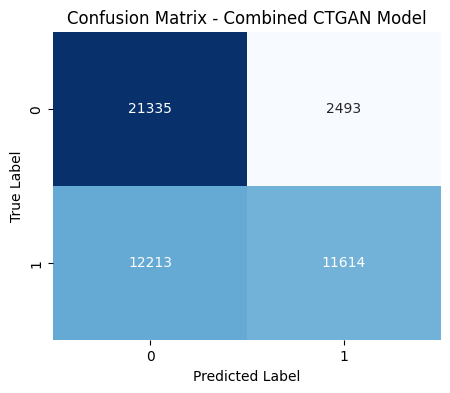

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Combined TVAE Model Evaluation:
  Accuracy:  0.6954
  F1 Score:  0.6361
  AUC-ROC:   0.7955
  Precision: 0.7900
  Recall:    0.5323
Confusion Matrix:
[[20456  3372]
 [11143 12684]]


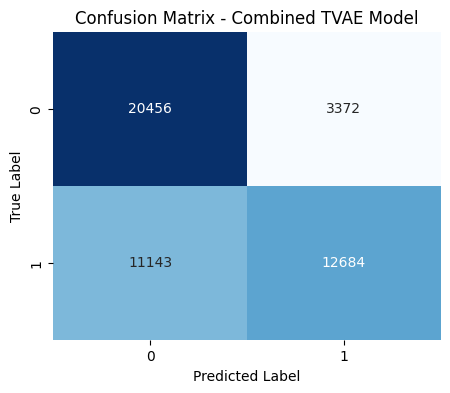

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Combined GReaT DistilGPT2 Model Evaluation:
  Accuracy:  0.7035
  F1 Score:  0.6688
  AUC-ROC:   0.7937
  Precision: 0.7572
  Recall:    0.5989
Confusion Matrix:
[[19253  4575]
 [ 9557 14270]]


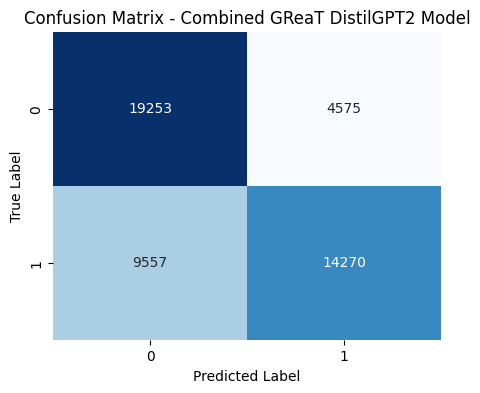

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:06:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Combined GReaT GPT2 Model Evaluation:
  Accuracy:  0.7086
  F1 Score:  0.6935
  AUC-ROC:   0.7941
  Precision: 0.7313
  Recall:    0.6594
Confusion Matrix:
[[18056  5772]
 [ 8116 15711]]


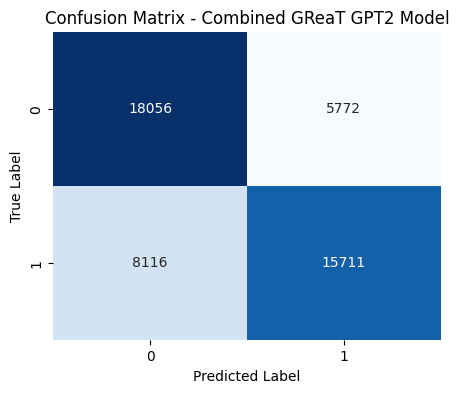

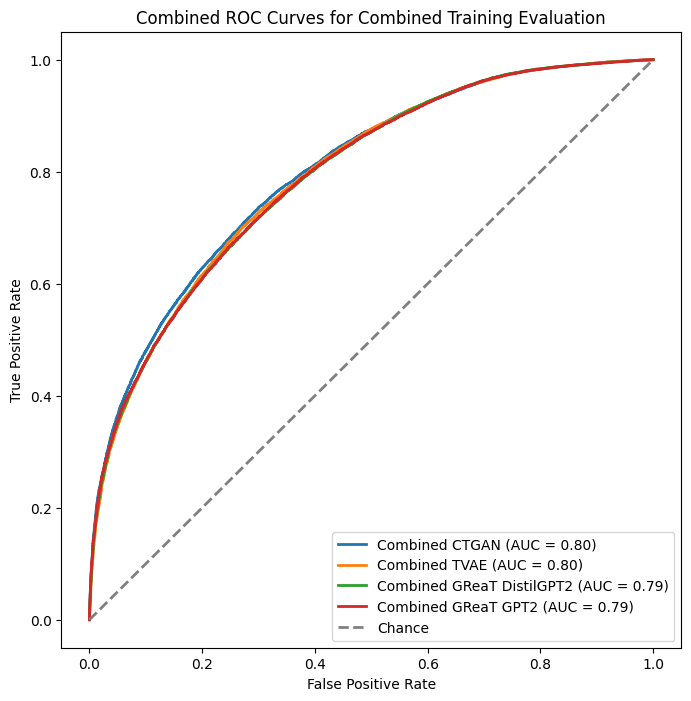

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score, confusion_matrix,
                             roc_curve, auc)

random_state = 42

# ---------------------------
# Step 1: Prepare the Datasets
# ---------------------------
# Assumed DataFrames:
# train_ads_minimal: full dataset with both labels (shape: (7,675,517, 17))
# train_ads_minimal_label1: real label 1 data (shape: (119,136, 17))
# syntetic_data_label1_CTGAN: CTGAN-synthesized data for label 1 (shape: (119,136, 17))
# syntetic_data_label1_TVAE: TVAE-synthesized data for label 1 (shape: (119,136, 17))
# syntetic_data_label1_GReaT_DistilGPT2: GReaT-DistilGPT2-synthesized data for label 1 (shape: (119,136, 17))
# syntetic_data_label1_GReaT_GPT2: GReaT-GPT2-synthesized data for label 1 (shape: (119,136, 17))

# Extract real label 0 (majority class)
real_label0 = train_ads_minimal[train_ads_minimal["label"] == 0]

# Number of real label 1 samples
n_label1 = len(train_ads_minimal_label1)

# For combined training, we form the new minority class by merging real label 1 with synthetic label 1.
# Since the combined minority size doubles (real + synthetic), we sample real label 0 to match this combined count.
real_label0_sample_combined = real_label0.sample(n=2 * n_label1, random_state=random_state)

# Create combined minority sets for each method:
combined_label1_CTGAN = pd.concat([train_ads_minimal_label1, syntetic_data_label1_CTGAN], axis=0)
combined_label1_TVAE = pd.concat([train_ads_minimal_label1, syntetic_data_label1_TVAE], axis=0)
combined_label1_GReaT_DistilGPT2 = pd.concat([train_ads_minimal_label1, syntetic_data_label1_GReaT_DistilGPT2], axis=0)
combined_label1_GReaT_GPT2 = pd.concat([train_ads_minimal_label1, syntetic_data_label1_GReaT_GPT2], axis=0)

# Form augmented (combined training) datasets by combining the sampled majority with the combined minority:
augmented_CTGAN = pd.concat([real_label0_sample_combined, combined_label1_CTGAN], axis=0)
augmented_TVAE = pd.concat([real_label0_sample_combined, combined_label1_TVAE], axis=0)
augmented_GReaT_DistilGPT2 = pd.concat([real_label0_sample_combined, combined_label1_GReaT_DistilGPT2], axis=0)
augmented_GReaT_GPT2 = pd.concat([real_label0_sample_combined, combined_label1_GReaT_GPT2], axis=0)

# For evaluation, we create a real test set using only genuine data.
# Here, we form a balanced set using real label 0 (sampled to match real label 1 count) and real label 1.
real_label0_sample_balanced = real_label0.sample(n=n_label1, random_state=random_state)
real_balanced = pd.concat([real_label0_sample_balanced, train_ads_minimal_label1], axis=0)

X_real = real_balanced.drop(columns=["label"])
y_real = real_balanced["label"]
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=random_state, stratify=y_real
)

# ---------------------------
# Step 2: Train and Evaluate Models with XGBoost
# ---------------------------
def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"{dataset_name} Evaluation:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  AUC-ROC:   {auc_val:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")

    # Confusion matrix and plot
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return model

# Train models on the augmented (combined) training sets
# CTGAN Combined Model
X_train_CTGAN = augmented_CTGAN.drop(columns=["label"])
y_train_CTGAN = augmented_CTGAN["label"]
model_CTGAN_combined = train_and_evaluate(X_train_CTGAN, y_train_CTGAN, X_test_real, y_test_real, "Combined CTGAN Model")

# TVAE Combined Model
X_train_TVAE = augmented_TVAE.drop(columns=["label"])
y_train_TVAE = augmented_TVAE["label"]
model_TVAE_combined = train_and_evaluate(X_train_TVAE, y_train_TVAE, X_test_real, y_test_real, "Combined TVAE Model")

# GReaT DistilGPT2 Combined Model
X_train_GReaT_DistilGPT2 = augmented_GReaT_DistilGPT2.drop(columns=["label"])
y_train_GReaT_DistilGPT2 = augmented_GReaT_DistilGPT2["label"]
model_GReaT_DistilGPT2_combined = train_and_evaluate(X_train_GReaT_DistilGPT2, y_train_GReaT_DistilGPT2, X_test_real, y_test_real, "Combined GReaT DistilGPT2 Model")

# GReaT GPT2 Combined Model
X_train_GReaT_GPT2 = augmented_GReaT_GPT2.drop(columns=["label"])
y_train_GReaT_GPT2 = augmented_GReaT_GPT2["label"]
model_GReaT_GPT2_combined = train_and_evaluate(X_train_GReaT_GPT2, y_train_GReaT_GPT2, X_test_real, y_test_real, "Combined GReaT GPT2 Model")

# ---------------------------
# Step 3: Plot Combined ROC Curves (Optional)
# ---------------------------
def plot_combined_roc(models, X_test, y_test, labels, title="Combined ROC Curves for Combined Training Evaluation"):
    plt.figure(figsize=(8, 8))
    for model, label in zip(models, labels):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc_val:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_combined_roc(
    models=[model_CTGAN_combined, model_TVAE_combined, model_GReaT_DistilGPT2_combined, model_GReaT_GPT2_combined],
    X_test=X_test_real,
    y_test=y_test_real,
    labels=["Combined CTGAN", "Combined TVAE", "Combined GReaT DistilGPT2", "Combined GReaT GPT2"]
)
